# Solar Charge Predictor #
## Contents
1. Introduction
2. Data Preparation
    1. Data Collection
    1. Importing Data
    1. One Hot Encoding
3. Exploratory Analysis
    1. Correlations Heatmap
    1. Relationships of Factors
    1. Spread of Categorical Variables
4. Regression Modelling
    1. Selection
    1. Selected Model
    1. User Interface
6. Conclusion

## 1. Introduction
Given the economy 7 electricity tariff, using electricity from the grid at night is cheaper than during the day. It is cost-effective to charge the house battery at night, and discharge it during the day when electricity is expensive to import. However, given a battery and solar panels, if batteries are charged excessively, then the excess generated by the solar panels (during daytime) will be exported for less than it costs to import from the grid (at the nighttime rate).

Therefore, factors are selected to predict what percentage charge of battery should be required on a given day. Weather factors are provided by www.visualcrossing.com for the author's location.

Of the raw data, I will begin with the following factors:

Table 1: Factor Description

| Factor        |      Description             | Values   | 
|:--------------|:-----------------------------|:------:|
|Day            | Day of the week (precategorised)| Weekday, Saturday, Sunday, Monday | 
|prec_cover     | The percent of precipitation cover | % |
|cloud_cover    | The percent of cloud cover   | % |
|solar_energy   | Units of solar energy        | float |
|sunset         | Time at which the sun sets as a fraction of 24 hours | float (0-1) |
|charge_to      | The ideal % to charge the battery to    | % |

## 2. Data Preparation ##

### 2. A. Data Collection ###
Data regarding the photovoltaic system was extracted from the APK of the inverter manufacturer. Given that the battery was charged to some % at night, the optimal charge_to % would have to be calculated from the grid export (KWh) or % free battery space. Therefore, this was calculated in excel via a formula following this logic:

```
if peak_percent >= 98: #when exporting
    if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
        charge_to = 0
    else: #otherwise you should have left how much was exported as free space
        charge_to = charged_percent - (100*(export/10.12))
else: # no export
    if peak_percent < 23: #if peak lower than 23% charge fully
        charge_to = 100
    elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
        charge_to = 100
    else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
        charge_to = 100-peak_percent+charged_percent
```

The data collection spreadsheet can be viewed in an attached file.

In [1]:
def what_charge(peak_percent, charged_percent, export):
    if peak_percent >= 98: #when exporting
        if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
            charge_to = 0
        else: #otherwise you should have left how much was exported as free space
            charge_to = charged_percent - (100*(export/10.12))
    else: # no export
        if peak_percent < 23: #if peak lower than 23% charge fully
            charge_to = 100
        elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
            charge_to = 100
        else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
            charge_to = 100-peak_percent+charged_percent
    return charge_to

what_charge(49,22,0)

73

### 2. B. Importing Data
Table 2 shows the start and end of the solar. This 'raw' data was inputted by the author and has been checked for errors.

In [1]:
import pandas as pd

df = pd.read_csv("feb_data.csv")
print("Table 2: Raw Data")
df

Table 2: Raw Data


,day,max_temp,prec_cover,cloud_cover,solar_energy,sunset,charge_to
0,Weekday,14.8,8.33,59.4,8.1,0.762188,98.000000
1,Saturday,14.9,29.17,59.5,9.3,0.757465,92.617188
2,Sunday,15.0,8.33,30.6,11.1,0.755903,76.000000
3,Monday,17.0,8.33,32.6,10.1,0.754363,84.687500
4,Weekday,15.9,0.00,6.7,10.5,0.752824,52.273438
...,...,...,...,...,...,...,...
480,Monday,8.9,20.83,44.1,8.5,0.715822,100.000000
481,Weekday,10.0,50.00,76.1,1.7,0.717164,100.000000
482,Weekday,14.0,16.67,75.2,2.7,0.718507,100.000000
483,Weekday,16.9,37.50,72.3,4.7,0.719850,100.000000


## Regression Modeling ##
Since one factor is to be used, this prediction can be completed via a simple regression. However, exponentials will be compared to control complexity and increase validation accuracy.
### 4. Selection ###
Selecting the one feature solar_energy and creating train and test set.

In [2]:
from sklearn.model_selection import train_test_split

selected = df[["solar_energy", "charge_to"]]

X = selected["solar_energy"].to_numpy()
y = selected["charge_to"].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=2)

Fitting with lines with exponential orders 1 - 9.

In [3]:
import numpy as np

orders = range(1,9)
x_LS = np.linspace(1,30,100).T

MSE_Train = dict.fromkeys(orders)
MSE_Val = dict.fromkeys(orders)
AMSE_Train = dict.fromkeys(orders)
AMSE_Val = dict.fromkeys(orders)

for order in orders:
    p = np.poly1d(np.polyfit(X_train, y_train, int(order)))

    MSE_Train[order] = np.sum((y_train - p(X_train))**2)/10
    MSE_Val[order] = np.sum((y_val - p(X_val))**2)/20
    AMSE_Train[order] = MSE_Train[order]/len(X_train)
    AMSE_Val[order] = MSE_Val[order]/len(X_val)
    
errors = pd.DataFrame({'Order' : orders, 'MSE Train' : list(MSE_Train.values()), 'MSE Val' : list(MSE_Val.values()), 
                      'Mean MSE Train' : list(AMSE_Train.values()), 'Mean MSE Val' : list(AMSE_Val.values())})

Figure 6: MSE error of various orders


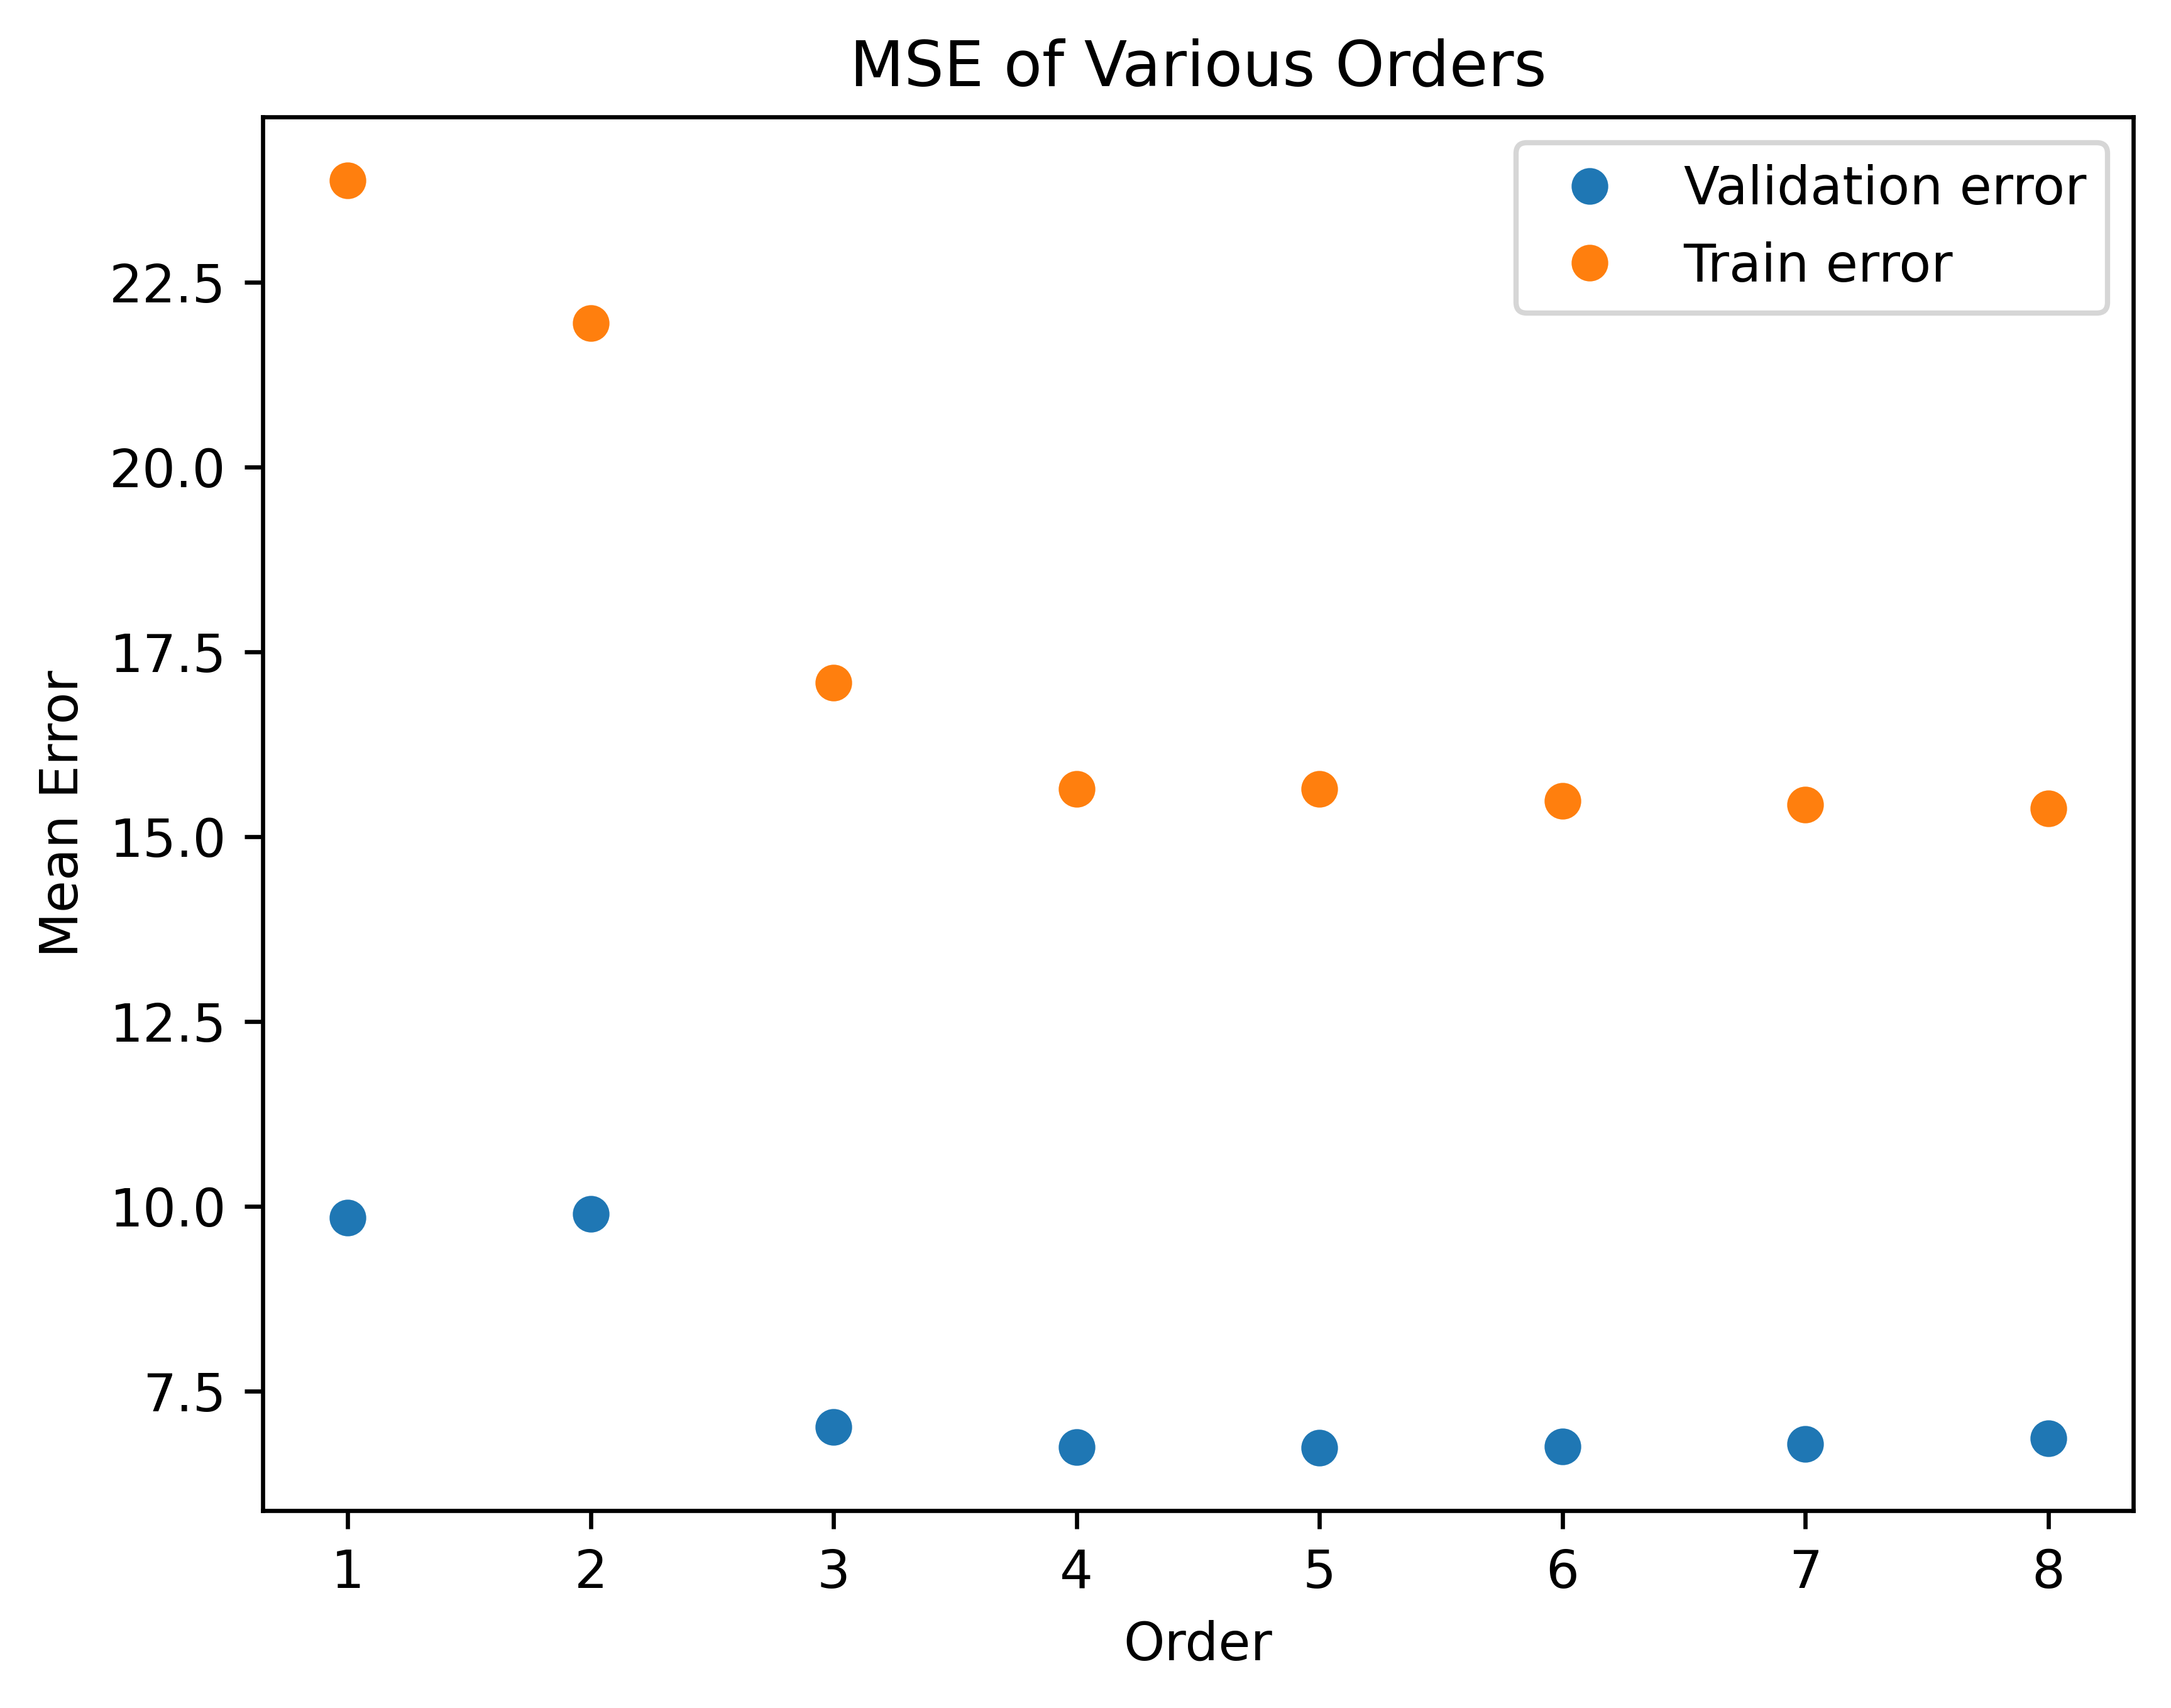

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
print("Figure 6: MSE error of various orders")

fig, a1 = plt.subplots(1, 1, dpi = 600)

a1.plot(errors.loc[:, "Order"], errors.loc[:, "Mean MSE Val"], 'o', label='Validation error')
a1.plot(errors.loc[:, "Order"], errors.loc[:, "Mean MSE Train"], 'o', label='Train error')
a1.set_xlabel("Order")
a1.set_ylabel("Mean Error")
a1.set_title("MSE of Various Orders")
a1.legend(loc='upper right')

The order of 4 is where the validation error is minimum.

### 4. B. Selected Model ##

The coefficients of the fitted model are:
 [-1.26064408e-03  8.60949667e-02 -1.78134583e+00  6.84771540e+00
  9.42715085e+01] 
---
The fitted model is:            4           3         2
-0.001261 x + 0.08609 x - 1.781 x + 6.848 x + 94.27



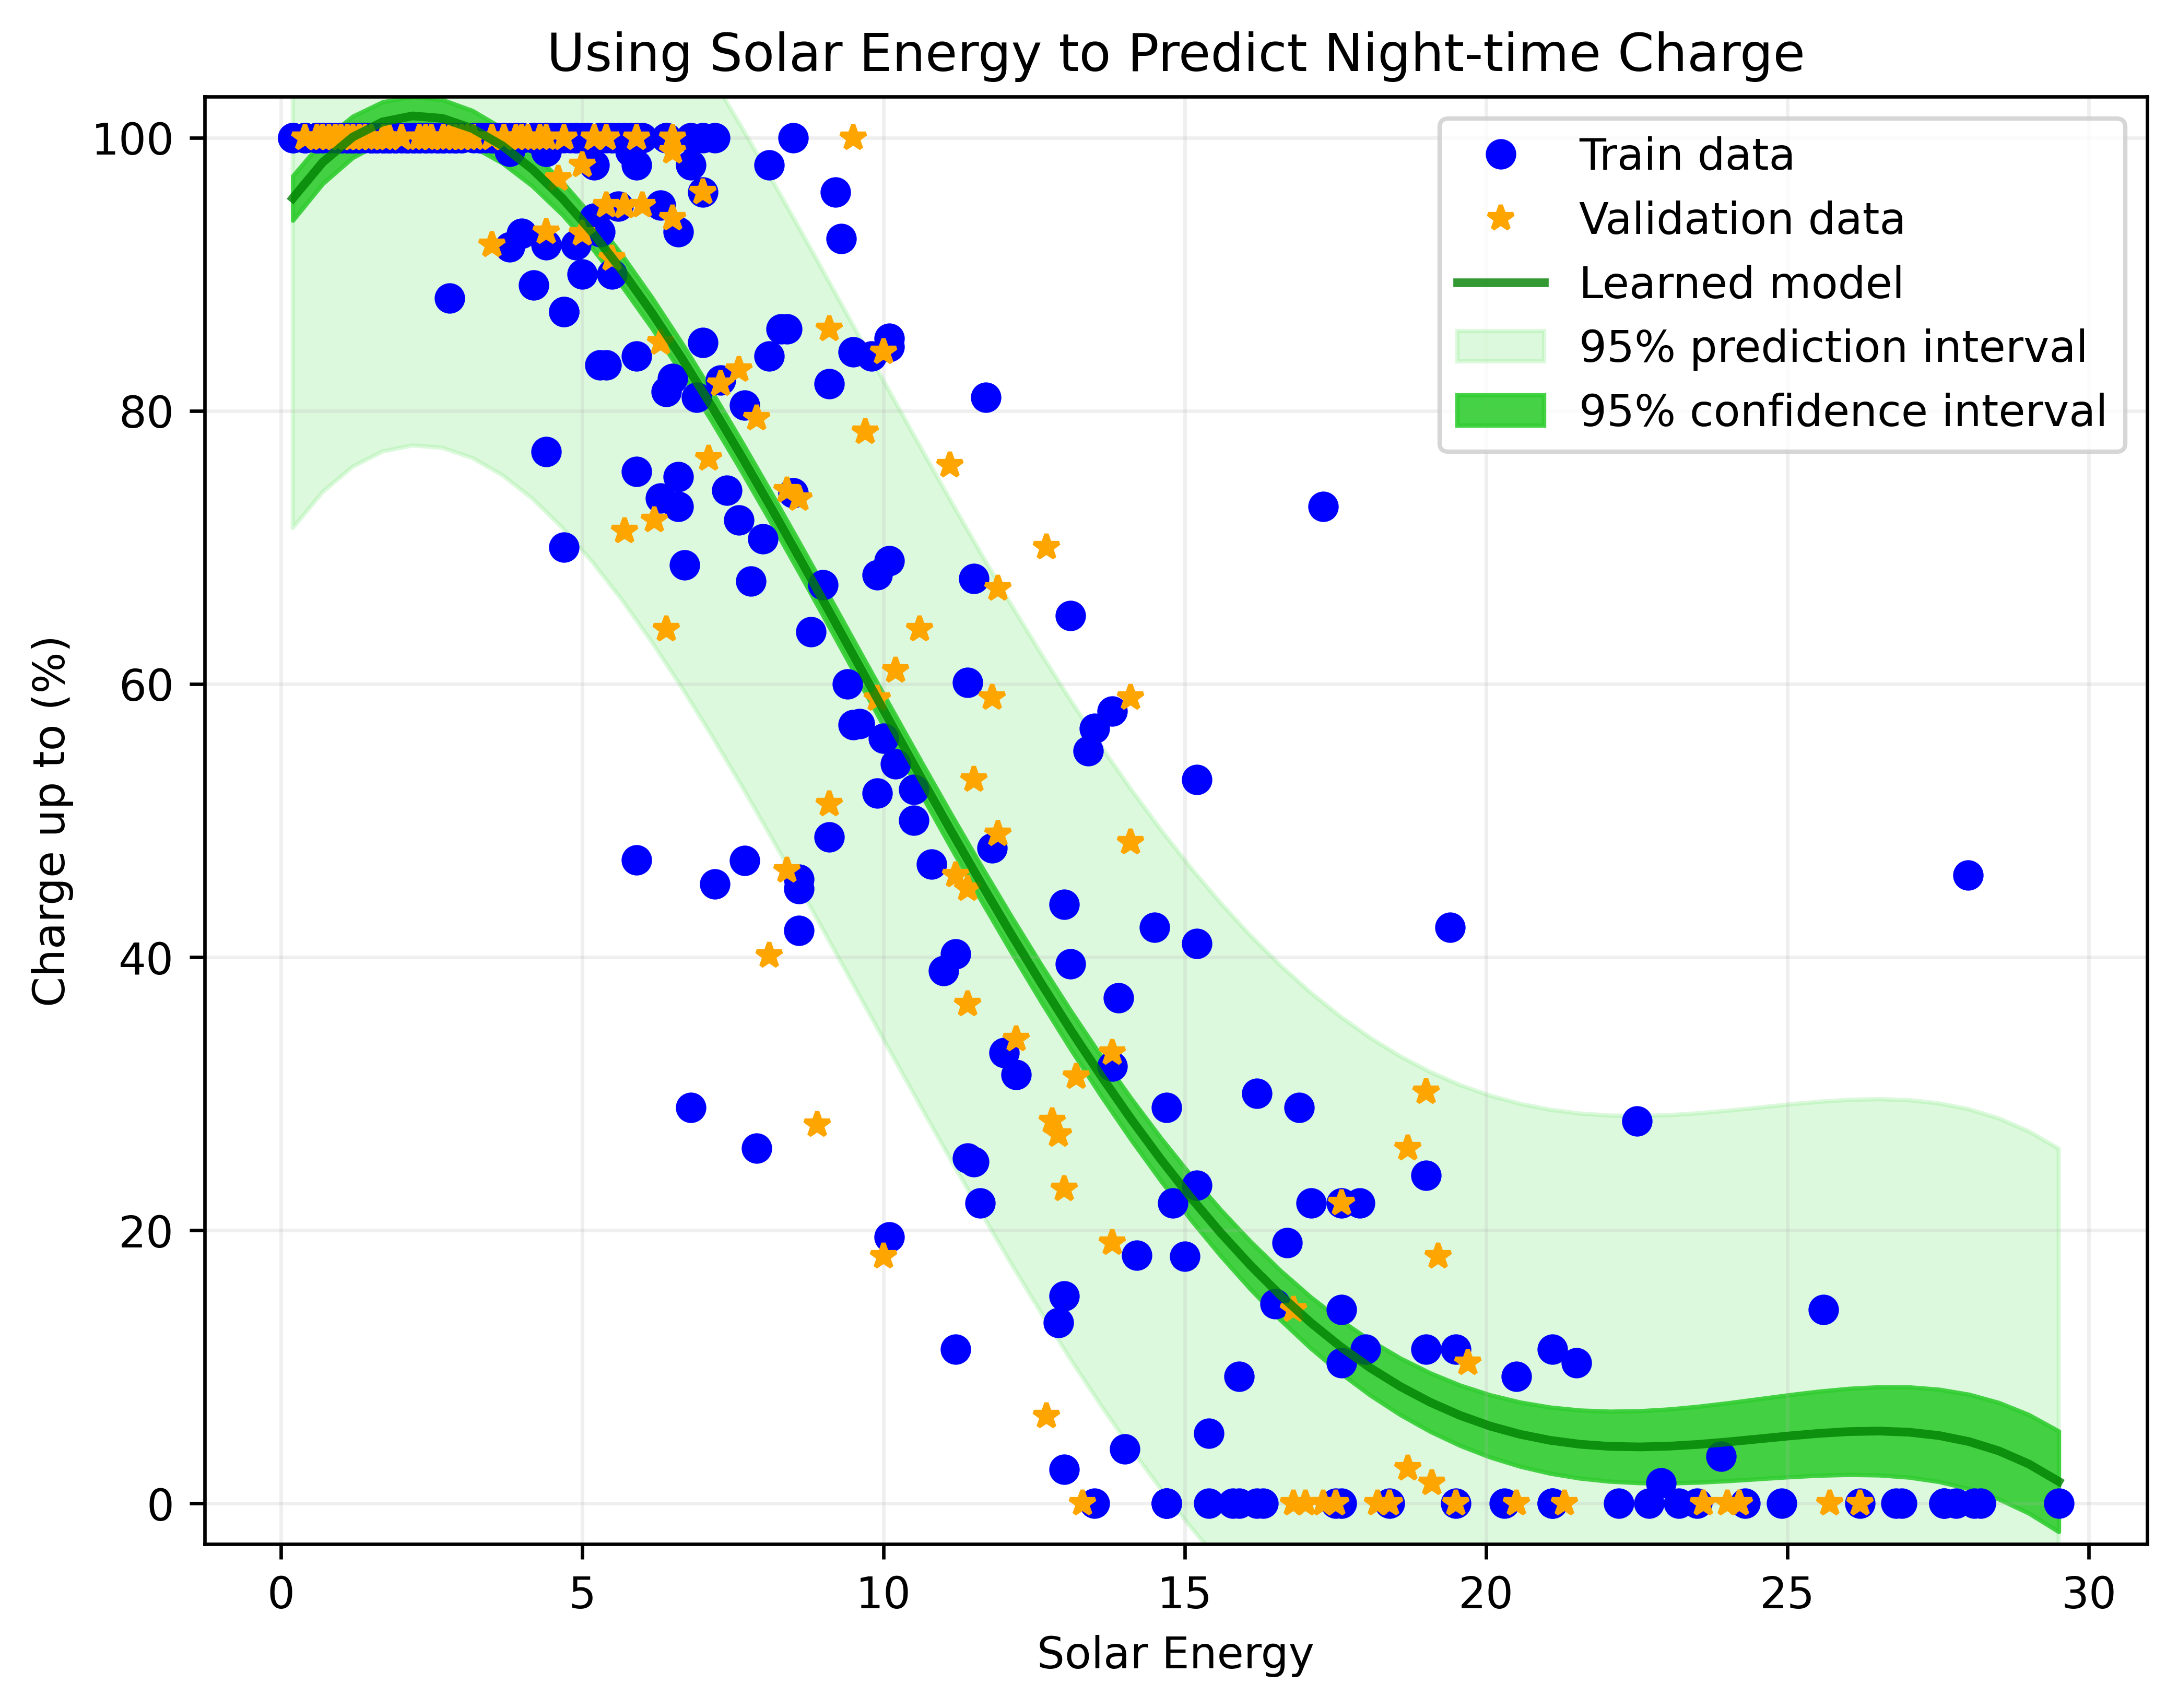

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import random

# Modelling
order = 4
model = np.polyfit(X, y, int(order))
p = np.poly1d(model) # model
y_model = np.polyval(model, X) #evaluation
residual = y - y_model

# Stats
x_mean = np.mean(X)
y_mean = np.mean(y)
n = X.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

x_LS = np.linspace(np.min(X), np.max(X),60).T # x values to make line
y_line = p(x_LS)

# confidence interval
ci = t * std_error * (1/n + (x_LS - x_mean)**2 / np.sum((X - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_LS - x_mean)**2 / np.sum((X - x_mean)**2))**.5



# Plotting
fig, a1 = plt.subplots(1, 1, dpi = 600, figsize=(8,6))

# Data
a1.plot(X_train, y_train, 'o', color='blue', label='Train data')
a1.plot(X_val, y_val, '*', color='orange', label='Validation data')
a1.plot(x_LS, y_line, '-', color='green', alpha=0.8, label='Learned model', linewidth=2)

# Intervals
a1.fill_between(x_LS, y_line + pi, y_line - pi, color='lightgreen', alpha=0.3, label='95% prediction interval')
a1.fill_between(x_LS, y_line + ci, y_line - ci, color='limegreen', alpha=0.9, label='95% confidence interval')

a1.set_title("Using Solar Energy to Predict Night-time Charge")
a1.set_xlabel("Solar Energy")
a1.set_ylabel("Charge up to (%)")
a1.grid(alpha=0.2)
a1.legend(loc='upper right')
a1.set_ylim(-3,103)

print('The coefficients of the fitted model are:\n {} \n---'.format(p.c))
print('The fitted model is: {}\n'.format(p))

## 4. C. User Interface ##
Battery percentage cannot be above 100%, nor should it discharge below 22% for longevity. Run the cell below for a prediction.

In [11]:
energy = float(input("Enter solar energy: "))

if int(p(energy)) > 100:
    bounded = 100
elif int(p(energy)) < 0:
    bounded = 0
else:
    bounded = int(p(energy))
    
# predicting interval
pi = t * std_error * (1 + 1/n + (energy - x_mean)**2 / np.sum((X - x_mean)**2))**.5
print(f"t value: {t} | standard error: {std_error} | x_mean: {x_mean} | denominator: {(np.sum(X - x_mean))**2}")
print(f"n: {n}")

print(f"95% prediction: {int(p(energy) - pi)}-{int(p(energy) + pi)}%")
print(f"Predicted exact: {int(bounded)}%")

Enter solar energy: 10
t value: 1.964887640611612 | standard error: 12.260422682240273 | x_mean: 7.664948453608248 | denominator: 1.2924697071141057e-26
n: 485
95% prediction: 33-82%
Predicted exact: 58%


# 5. Conclusion # 
This project set out to predict the best percentage to charge the house battery of the photo-voltaic system at night. Analysis of  weather factors show that the only feasible factor to predict this is solar energy, as other factors have little correlation with the label or are co-correlated.
The performance of regression of different exponents was compared, which resulted in the choosing of an order of 4, resulting in a regression line that follows the general trend of the relationship with low error and acceptable fitting.